#  Import Libraries

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pylab import rcParams
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Model, layers, models, optimizers, regularizers
from tensorflow.keras.layers import Input, Dropout, LSTM, TimeDistributed, RepeatVector, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# Load Data

In [2]:
train = pd.read_csv("Prophet/train.csv")
test = pd.read_csv("Prophet/test.csv")

train.head()

,Unnamed: 0,Timestamp,Svr_detect,Svr_connect,Ss_request,Ss_Established
0,0,2021-01-01 00:00:00,-0.016186,-0.416007,2.613224,-2.001920
1,1,2021-01-01 00:10:00,-0.016187,-0.417978,1.613015,3.997872
2,2,2021-01-01 00:20:00,-0.016188,-0.419948,-1.387194,-0.002336
3,3,2021-01-01 00:30:00,-0.016190,-0.421918,-1.387403,3.997456
4,4,2021-01-01 00:40:00,-0.016191,-0.423889,-0.387612,-1.002753


In [3]:
train.drop("Unnamed: 0", inplace=True, axis=1)
test.drop("Unnamed: 0", inplace=True, axis=1)

In [4]:
train.set_index("Timestamp", inplace=True, drop=True)
test.set_index("Timestamp", inplace=True, drop=True)

In [5]:
train.head()

,Svr_detect,Svr_connect,Ss_request,Ss_Established
Timestamp,,,,
2021-01-01 00:00:00,-0.016186,-0.416007,2.613224,-2.001920
2021-01-01 00:10:00,-0.016187,-0.417978,1.613015,3.997872
2021-01-01 00:20:00,-0.016188,-0.419948,-1.387194,-0.002336
2021-01-01 00:30:00,-0.016190,-0.421918,-1.387403,3.997456
2021-01-01 00:40:00,-0.016191,-0.423889,-0.387612,-1.002753


In [6]:
n_features = train.shape[1]
print(n_features)

4


# standardization

In [7]:
scaler = preprocessing.StandardScaler().fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

# Transform to Series Data, train test split

In [8]:
train_set = train_scaled.reshape(len(train_scaled), 1, 4)[len(train_scaled)// 10 * 7:]
valid_set = train_scaled.reshape(len(train_scaled), 1, 4)[:len(train_scaled)// 10 * 7]
test_set = test_scaled.reshape(len(test_scaled), 1, 4)

# Training LSTM Autoencoder

In [9]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(140, activation='relu', return_sequences=True, kernel_regularizer=regularizers. l2(0.00))(inputs)
    
    L2 = LSTM(70, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(70, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(140, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [10]:
model = autoencoder_model(train_set)
model.compile(optimizer='adam', loss='mse')
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "model"
_________________________________________________________________


2022-05-04 13:29:39.920496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-04 13:29:39.920674: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 140)            81200     
                                                                 
 lstm_1 (LSTM)               (None, 70)                59080     
                                                                 
 repeat_vector (RepeatVector  (None, 1, 70)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 70)             39480     
                                                                 
 lstm_3 (LSTM)               (None, 1, 140)            118160    
                                                                 
 time_distributed (TimeDistr  (None, 1, 4)             564       
 ibuted)  

In [14]:
model = autoencoder_model(train_set)
model.compile(optimizer='adam', loss='mse')

nb_eprochs = 1000
batch_size = 32
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]
history = model.fit(train_set, train_set, epochs=nb_eprochs, batch_size=batch_size, validation_data=(valid_set, valid_set), callbacks=callbacks)

Epoch 1/1000


2022-05-04 13:36:00.706551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


245/245 [==============================] - ETA: 0s - loss: 1.5188

2022-05-04 13:36:09.275511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


245/245 [==============================] - 15s 57ms/step - loss: 1.5188 - val_loss: 0.0918
Epoch 2/1000
245/245 [==============================] - 14s 55ms/step - loss: 0.7885 - val_loss: 0.0302
Epoch 3/1000
245/245 [==============================] - 14s 55ms/step - loss: 0.3455 - val_loss: 0.0299
Epoch 4/1000
245/245 [==============================] - 13s 53ms/step - loss: 0.5036 - val_loss: 0.0782
Epoch 5/1000
245/245 [==============================] - 13s 53ms/step - loss: 0.3176 - val_loss: 0.0086
Epoch 6/1000
245/245 [==============================] - 13s 55ms/step - loss: 0.0187 - val_loss: 0.0050
Epoch 7/1000
245/245 [==============================] - 13s 54ms/step - loss: 0.0080 - val_loss: 0.0034
Epoch 8/1000
245/245 [==============================] - 13s 53ms/step - loss: 0.0180 - val_loss: 0.0035
Epoch 9/1000
245/245 [==============================] - 13s 53ms/step - loss: 0.0464 - val_loss: 0.0029
Epoch 10/1000
245/245 [==============================] - 13s 53ms/step - loss

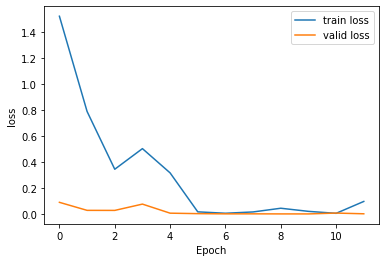

In [15]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="valid loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.show()

# Threshold

In [16]:
loss = model.predict(valid_set) - valid_set

2022-05-04 13:39:28.942459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [17]:
loss = loss.reshape(loss.shape[0], loss.shape[2])

In [18]:
all_loss = []
for i in range(len(loss)) :
    all_loss.append(np.sqrt(np.mean(loss[i]**2)))

In [19]:
threshold = np.mean(all_loss) +  24 * np.std(all_loss)
print(threshold)

1.0748248486399459


In [20]:
threshold = 0.5

# predict

In [21]:
best = pd.read_csv('autoencoder_best.csv')
test_predictions = model.predict(test_set)

2022-05-04 13:39:37.629232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [22]:
predict = []
for i in range(len(test_set)):
    if np.sqrt(np.mean((test_set - test_predictions)[i]**2)) > threshold:
        predict.append(1)
    else:
        predict.append(0)

In [23]:
pd.DataFrame(predict).value_counts()

0    26325
1      171
dtype: int64

In [24]:
predict_= pd.DataFrame(predict, columns=['Prediction_'])

In [25]:
cont = pd.concat([predict_, best['Prediction']], axis=1)

In [26]:
cont.head()

,Prediction_,Prediction
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [27]:
TT = cont[cont['Prediction_'] != cont['Prediction']]
TT[TT['Prediction_'] == 0]

,Prediction_,Prediction
161,0,1
162,0,1
163,0,1
496,0,1
497,0,1
...,...,...
21434,0,1
21995,0,1
25698,0,1
25699,0,1


In [28]:
TT.shape

(211, 2)

In [30]:
predict = []
for i in range(len(test_set)):
    if np.sqrt(np.mean((test_set - test_predictions)[i]**2)) > threshold:
        predict.append(1)
    else:
        predict.append(0)
pd.DataFrame(predict).value_counts()
predict_= pd.DataFrame(predict, columns=['Prediction'])
predict_.shape

(26496, 1)

In [33]:
predict_.to_csv('predict3.csv', mode='w')